## Udacity ML Engineering Nanodegree - Capstone Project

# Identifying attacker application sessions through supervised learning over known attacker sessions
## Project Domain
This project bears on the domain of security. I work for a company that publishes expensive content on the web, making it available to subscribers only. We frequently discover cases in which attackers have stolen credentials from our customers and use them to perform unauthorized content downloads. Detecting such activity quickly, without human analysis, has always been difficult given the large amounts of data involved.

## Problem Statement

Given a selection of log data containing records that describe different usage activities, determine whether a given session is likely to describe unauthorized content access. This project will use known attacker data as labeled examples supporting a supervised learning approach. I will use a supervised learning approach on labeled input data that includes both attacker sessions and “innocent” sessions, hoping to produce a model that can predict a high percentage of attack sessions with very low false positives. A successful proof of concept would identify 70% of attacker sessions with no more than 5% false positives.

## Datasets and Inputs

- known-attacker.txt–afilecontaininglogentriescollectedfromsessions manually identified as belonging to known attackers. Covering a span of around two years, this file contains ~60K attacker events.

- mixed1-3.txt – files containing an unfiltered selection of time intervals known to contain attacker activities. These files contain a total of ~200K events, of which less than 0.5% are attacker events.

The events in each file are recorded as tab-separated rows in the following columns:

SessionNo LogTime CustID GroupID ProfID Act BadActor

The ‘SessionNo’ column groups activities into sets of consecutive user actions, each of which is identified with an ‘Act’ column that identified what the user did, e.g., logged in, performed a search, downloaded content. The CustID, GroupID, and ProfID columns identify unique customer organizations, and are not expected to be useful in the learning exercise per se.

Each file has been labeled manually with a notation whether each event belongs to an attacker session. The ‘BadActor’ column indicates whether the given event belongs to an attacker session.

Given the low ratio of attacker to innocent events in the mixed files, I expect it will be necessary to augment the data to improve training results. [2016, Buczakak and Guven] suggests dropping negative rows or duplicating positive rows; I plan to augment training data using the long history of attacker-only rows in known-attacker.txt.

## Solution Statement

I will train a binary classifier model to distinguish attacker sessions from normal usage. My hypothesis is that attacker activity is distinctly different from normal usage in at least the following ways:
• An attacker logs in and begins downloading one ebook after another. A normal user will perform topic, title or author searches, read a few pages, and search again, browsing several pieces of content before choosing any one work to download.
• An attacker tends not to pause for long intervals between content accesses. A normal user will read at least part of a work before moving on to the next.
• An attacker’s session will often not last as long as a normal research session. After completing an attack, the attacker leaves immediately, while a researcher will do homework or study for hours.
These three distinctions suggest several approaches for feature engineering:
• Our logs distinguish around 40 distinct actions that users take when performing
research. Derive features that represent these actions across the course of a session.
• A straightforward method to model user think-time is to calculate some simple session metrics. Average think-time and (possibly) standard deviation of think-time seem likely
to capture a large fraction of the difference between attack and research.
• Session length should be easy to calculate and populate as a feature of a session.
My overall goal is to produce a model that will allow me to evaluate past log files looking for evidence of attacks, so that this information can be used to create rules in our perimeter security devices.

## Prior research
As far as I can see, the problem of identifying attackers from logs of activities at the business- use-case level has not been thoroughly researched. I did find numerous papers on analysis of net flows and HTTP logs that can be read for useful parallel techniques.

Pietraszek, Tadeusz and Axel Tanner. “Data mining and machine learning - Towards reducing false positives in intrusion detection.” Inf. Sec. Techn. Report 10 (2005): 169-183. Uses machine learning to identify candidate alerts from an IDS for human labeling. Labels are used in supervised learning to refine selection of alerts.

Buczak, Anna L. and Erhan Guven. “A Survey of Data Mining and Machine Learning Methods for Cyber Security Intrusion Detection.” IEEE Communications Surveys & Tutorials 18 (2016): 1153-1176. In the domain of IP net flow analysis, establishes terminology and reviews a broad selection of techniques for modeling attacks based on collections of internet packets.

Sperotto, Anna et al. “An Overview of IP Flow-Based Intrusion Detection.” IEEE Communications Surveys & Tutorials 12 (2010): 343-356. In-depth discussion of net flow analysis, distinguishing parts of the net-flow modeling problem rather than how to analyze collections of successfully-captured packets.

Moh, Melody et al. “Detecting Web Attacks Using Multi-stage Log Analysis.” 2016 IEEE 6th International Conference on Advanced Computing (IACC) (2016): 733-738. Overview of an approach for managing high volumes of HTTP logs and analyzing for presence of SQL injection attackes. Uses Bayes net classification in WEKA, produces an enriched analyst workstation environment in Kibana.

## Benchmark Model & Evaluation Metrics
The total volume of known attacker traffic is extremely low, less than .05% for a given victim. My approach to computing a baseline is to assume that *P(attack)* for a given row is 0. I will compare the confusion matrix for this baseline to the one for predictions from my ML model.

## Project Design
I will execute the following plan:

1. Import the data into Jupyter & SageMaker in order to study it in place 2. Choose an approach for feature engineering:

    a. Can I engineer a session row that contains enough information to produce a useful result in one of the algorithms I’ve already used, like XGBoost?

    b. Do I need to use LSTM or convolution or some other learning algorithm with a memory that can learn sequences?

3. Produce a repeatable process that can convert our raw log file into a dataset that my chosen algorithm can process

4. Train a model, and execute the model against labelled data in batch transform mode 5. Use the result to calculate true and false positives and negatives. Given the small population of positive results – attacker session are a small fraction of total traffic – precision and recall are the most important metrics.

    a. High precision means that my false positive rate is low. It’s critical not to misidentify innocent traffic as malicious.

    b. High recall is the next most important metric. I need to identify as great a fraction of actual attack traffic as possible.

The training set includes the following files:

|File       |Rows                             |Contents|
------------|-------------------------------------|----|
|mixed-1.txt|119474|raw transactions|
|mixed-2.txt|43608|raw transactions|
|mixed-3.txt|30844|raw transactions|
|known-attacker.txt|61917|raw transactions for a known attacker|

All files include a 'BadActor' column that labels a transaction as belonging to a known attacker or not. The 'mixed-' files consist of whole hours of activity in which there is an attack, while known-attacker.txt contains all attacks for the known attacker over the last two years. In all, we have 193926 transactions from "innocent" sessions and 61917 LT transactions. Approximately 32% of transactions are labeled BadActor = 1, giving us a reasonable proportion in both classes.

## Warm up
Import standard libraries and prepare the environment.

In [2]:
import io
import os
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 

import boto3
import sagemaker
from sagemaker import get_execution_role

!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [3]:
# sagemaker session, role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# S3 bucket name
bucket = sagemaker_session.default_bucket()

# common column names
bad_col='BadActor'
sess_col='SessionNo'
txn_col='Act'
logtime_col = 'LogTime'



## Download
Retrieve the datafiles from the project's designated S3 bucket.

In [4]:
mixed = []
for i in range(3):
    name = 'data/mixed-{}.txt'.format(i+1)
    m = pd.read_csv(name,sep='\t')
    m[logtime_col] = pd.to_datetime(m[logtime_col])
    m[txn_col]= m[txn_col].astype(str)
    print( "File: {} Rows: {}".format( name, len(m)))
    mixed.append(m)
    
# Load data for known attacker
name = 'data/known-attacker.txt'
# known = pd.read_csv(name ,sep='\t')

mixed = pd.concat(mixed)
known = mixed[mixed[bad_col]==1]
# known = pd.concat([known]*200)
print( f"File: known Rows: {len(known)}" )

File: data/mixed-1.txt Rows: 119474
File: data/mixed-2.txt Rows: 43608
File: data/mixed-3.txt Rows: 30844
File: known Rows: 533


In [5]:
# known[txn_col]= known[txn_col].astype(str)
# print( "File: {} Rows: {}".format( name, len(known)))

# Load data for extra day of test data - need to have full set of transaction types
name = 'data/single.txt'
single = pd.read_csv(name ,sep='\t')
single[txn_col]= single[txn_col].astype(str)

# txn = pd.concat([mixed,known])
txn = pd.concat([mixed])
print( "Total mixed transaction rows: {}".format(len(txn)))


Total mixed transaction rows: 193926


## Data conversion and feature engineering
In real life, a session consists of a series of rows of transactions of different types, and each transaction type records a variable number of additional metadata attributes describing a logged event, for a total of over 30 columns of extracted data. In addition, our tagging process has given each row a BadActor label.

|sessionno|txn id|BadActor|parm1|parm2|...|
|---------|------|--------|-----|-----|---|
|1240|111|0|query string|...|...|
|1240|112|0|meta|...|...|
|2993|301|1|meta|...|...|


In [35]:
# 'Innocent' log entries
txns = pd.DataFrame(np.sort(txn['Act'].unique()))

# Harvesting log entries
bad_txns = pd.DataFrame(txn[txn[bad_col]==1])

all_txns=pd.concat([txn,single])

all_txn_types = np.sort(all_txns[txn_col].unique())
len(all_txn_types), len(txn)


(35, 193926)

## Analyzing transaction prevalence among normal and attack transactions
Transaction types appear in the data samples in different frequencies. Note the long-tailed distribution of transaction types in the population of all transactions. The top 10 transactions constitute over 91% of the total population.

In [36]:
all_txn_counts = pd.DataFrame(txn[txn_col].value_counts())
all_txn_counts.head(10).sum()/all_txn_counts.sum()

Act    0.914003
dtype: float64

In [37]:
all_txn_counts.head(10)

,Act
115,37505
121,30374
201,29607
127,20327
111,16311
126,14349
117,9581
116,7874
411,5773
410,5548


In [20]:
pd.DataFrame(txn[txn_col].value_counts().head(10)).sum()

Act    177249
dtype: int64

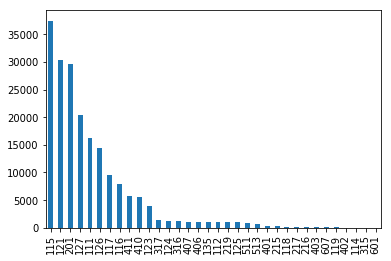

In [7]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
txn[txn_col].value_counts().plot(ax=ax, kind='bar')

Among attack sessions, the transaction population is markedly different. 

In [48]:
bad_txn_counts = pd.DataFrame(bad_txns[txn_col].value_counts())
bad_txn_counts.head(10).sum()/bad_txn_counts.sum()

Act    0.984991
dtype: float64

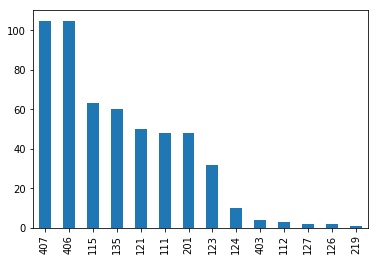

In [53]:
fig, ax = plt.subplots()
bad_txns[txn_col].value_counts().plot(ax=ax, kind='bar')

In [50]:
bad_txn_counts.head(10)

,Act
407,105
406,105
115,63
135,60
121,50
111,48
201,48
123,32
124,10
403,4


Comparing top-10 lists between positive and negative sessions, we see that most of the top-10 transactions overall do not appear in attack sessions. This suggests an additional experiment in which we filter out all of the top-10 transactions entirely.

In [49]:
pd.DataFrame( {"bad":bad_txn_counts['Act'], "all":all_txn_counts['Act']})

,bad,all
111,48.0,16311
112,3.0,1039
114,NaN,11
115,63.0,37505
116,NaN,7874
117,NaN,9581
118,NaN,104
119,NaN,39
121,50.0,30374
123,32.0,3981


In [107]:
top_n = txn[txn_col].value_counts().reset_index()['index']
top10 = set(top_n.head(10).tail(8))

txn_top_10 = txn[txn[txn_col].isin(top10)]
txn_filter = txn[~txn[txn_col].isin(top10)]
len(txn_filter[txn_filter[bad_col]==1]),len(txn_top_10[txn_top_10[bad_col]==1]),len(txn[txn[bad_col]==1])
txn_drop10=txn_filter

# Flattening transactions into sessions.
We drop most of this information, including the temporal sequence of the log entries, and convert each session into a single row of data. Almost all of the columns go away, replaced by counts of transaction types in the session.

|sessionno|BadActor|111|112|113|...|301|302|...|
|---------|--------|---|---|---|---|---|---|---|
|1240|0|1|1|0|...|0|0|...|
|2993|1|0|0|0|...|1|0|...|

In [108]:
def add_missing_columns( df_target, source_cols):
    '''
    If there are columns in the list 'source' that are not in the DataFrame 'target',
    add new columns to 'target' that are populated with 0.0.
    '''
    df = df_target
    target_cols = df_target.columns
    missing_cols = set(source_cols) - set(target_cols)
    
    if 0 < len(missing_cols):
        print( "Missing columns: {}".format(missing_cols)) 
        new_cols = dict([(col,0.0) for col in missing_cols])
        df = df_target.assign(**new_cols)
    
    return df

def flatten_txns( txn_log ):
    txn_narrow = txn_log[[sess_col, txn_col,bad_col]]
    txn_pivot = pd.pivot_table(txn_narrow, index=[sess_col,bad_col], columns = [txn_col],aggfunc=[len]).fillna(0)
    txn_pivot.columns = txn_pivot.columns.droplevel(0)           # the pivot table has a two-level index
    txn_flat = txn_pivot.rename_axis(None, axis=1).reset_index() # these two lines get rid of it so we have a simple table
    
    
    txn_full = add_missing_columns(txn_flat, all_txn_types)
    txn_xs = txn_full.drop(columns=[sess_col,bad_col])
    txn_xs = txn_xs.reindex(sorted(txn_xs.columns), axis=1)

    txn_sort = pd.concat([txn_full[[sess_col,bad_col]], txn_xs],sort=True,axis=1)
    return txn_sort

# Compute event statistics - "wait times"
We expect that the behaviors shown in event traces of innocent research sessions will differ from those in harvesting sessions. Researchers will exhibit variable waits between events, time for thought, reading, or checking citations; harvesters will search for a work and then leave. 

With this in mind, we compute statistics for time intervals between events in sessions, as well as metrics for sessions overall, and add features to the set.

In [109]:
def add_wait_times(txns):
    # sort by session and logtime
    txng = txns.set_index(['SessionNo','LogTime']).sort_index() 

    # remove the index so we can compute on log time values
    txng.reset_index(inplace=True)
    
    # subtract the previous row's logtime from this rows logtime
    txng['Wait'] = pd.to_timedelta(txng[logtime_col].diff() ).astype('timedelta64[s]')
    
    # add the session back to the index so that we can flag session starts
    txng = txng.set_index(['SessionNo']).sort_index() 
    
    # if the current session value is different, set the wait time to 0
    s = pd.Series(txng.index)
    session_starts = (s != s.shift()).values
    txng.loc[session_starts,'Wait'] = 0
    
    return txng


def compute_wait_stats(txnw):
    txnw_g = txnw.reset_index()[[sess_col,'Wait']]
    txnw_g = txnw_g.groupby(sess_col)
    txnw_stat = txnw_g.agg([np.mean,np.std,np.sum,np.min,np.max,len]).fillna(0)
    txnw_stat.columns = txnw_stat.columns.droplevel(0)  
    txnw_stat.rename_axis(None, axis=1).reset_index()
    return txnw_stat

txnw  = add_wait_times(txn)
txn_wait_stats = compute_wait_stats(txnw)

In [110]:
def compute_session_stats( txn ):
    txng = txn[[sess_col,'LogTime']].groupby(sess_col)
    txn_sess = txng.agg([np.min,np.max])
    txn_sess.columns = txn_sess.columns.droplevel(0)  
    txn_sess.rename_axis(None, axis=1).reset_index()
    txn_sess['length'] = pd.to_timedelta((txn_sess['amax'] - txn_sess['amin'])).astype('timedelta64[s]')
    return txn_sess

txn_session_stats = compute_session_stats( txn )
# txn_session_stats

# Combining timing and session data with transaction data

On review, the session data is a simple subset of the wait times data - the total session time is already the 'sum' column, and the min-max times aren't really trainable - we'd need to adjust them to local tz or something.

We can conduct many experiments with these additional time-related datasets:

1. ~~Train on each one individually to assess its value in a model~~
2. ~~Combine them, and see a) whether they improve together and b) which is a better predictor than the other~~
3. Only Wait stats is interesting.
4. ~~Combine session stats + txn counts~~
4. Combine wait stats + txn counts 

For now, we're just going to use txns and wait stats.

In [130]:
from sklearn import preprocessing as skp

def prep_txn_df(txn):
    '''
    Flatten and augment a file of txn data.
    Given a df of data in raw transaction format, return a df of data in session format
    Relies on a global all_txn_types listing all possible txn_type values for the set.
    '''
    
    # Clean up column types.
    txn[logtime_col] = pd.to_datetime(txn[logtime_col])
    txn[txn_col]= txn[txn_col].astype(str)

    # Filter out the most common transactions.
    
    # Flatten
    flat = flatten_txns(txn)
    
    # Add session timings
    txnw  = add_wait_times(txn)
    txn_wait_stats = compute_wait_stats(txnw)
    wide = flat.merge( txn_wait_stats, on=sess_col, suffixes=['base', 'wait'] )

    # scale everything into 0..1 range
    cols = wide.columns
    sessions=wide[sess_col]
    min_max_scaler = skp.MinMaxScaler()
    wide_minmax = pd.DataFrame(min_max_scaler.fit_transform(wide))
    wide_minmax.columns = cols
    wide_minmax[sess_col]=sessions
    return wide_minmax

base = prep_txn_df(txn)


Missing columns: {'312'}


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [131]:
base.head(5)

,SessionNo,BadActor,111,112,114,115,116,117,118,119,...,511,513,601,607,mean,std,sum,amin,amax,len
0,-2147481927,0.0,1.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
1,-2147317281,0.0,1.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000722,0.000716,0.000354,0.0,0.000547,0.000114
2,-2147002735,0.0,1.0,0.000000,0.0,0.002561,0.028571,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000957,0.000592,0.000704,0.0,0.000567,0.000189
3,-2146953899,0.0,0.0,0.076923,0.0,0.025608,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.004683,0.006463,0.021245,0.0,0.013973,0.001362
4,-2146926264,0.0,1.0,0.000000,0.0,0.001280,0.000000,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000010,0.000010,0.000004,0.0,0.000007,0.000076


## Producing pools of training and testing data

We will divide the combined good and bad data pools as follows:
- a training set that the model iterates over during the learning process
- a test set that is used to evaluate the model during training
- a validation set that is kept separate to test the model after training is complete. We need separate test and validate pools in order to make sure that we're overfitting the model to a single set of test data.

In [132]:
def split_frame( df, train_frac ):
    l = len(df)
    test_frac = (1-train_frac)/2
    tr = int(train_frac * l)
    te = int(tr + test_frac * l)
    
    train = df[:tr]
    test = df[tr:te]
    val = df[te:]
    return [train, test, val]

In [133]:
def train_split( flat, bad_split=.8 ):
    bad = flat[flat[bad_col]==1]
    good = flat[flat[bad_col]==0]
    
    bads = split_frame(bad, bad_split)
    goods = split_frame(good, bad_split)
    
    dfs = []
    for i in range(3):
        # Dropping the session # because we don't want to train on it.
        # Also leaves our label - BadActor - in the 0 column, as XGBoost requires for CSV
        df = bads[i].append(goods[i]).drop(sess_col,axis=1).sample(frac=1)
        dfs.append( df )
    
    return dfs
    


# Split the data and upload to S3
Break the set into train, test, and validation collections and output CSV's.
As Sagemaker requires, leave out row indices and column headers.

In [134]:
dfs = train_split(base, .4)

!mkdir output

s3_client = boto3.client('s3')
bucket = "sk-mlai-harvesting"

for i, df in enumerate(dfs):
    files = ["train","test","validate"]
    file = "output/{}.csv".format(files[i])
#     df.to_csv(path_or_buf= file, header=False, index=False  )
    df.to_csv(path_or_buf= file, index=False , header=None )

    print("Uploading {} to {}".format(file, bucket))

    response = s3_client.upload_file(file, bucket, file)
    print(response)
    
    
    


mkdir: cannot create directory ‘output’: File exists
Uploading output/train.csv to sk-mlai-harvesting
None
Uploading output/test.csv to sk-mlai-harvesting
None
Uploading output/validate.csv to sk-mlai-harvesting
None


# Prepare and train a model
Boilerplate code mostly copied from Amazon sample code at https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/xgboost_abalone/xgboost_abalone.ipynb, with ample room for improvement.

In [135]:
### %%time
region = 'us-east-1'
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(region, 'xgboost')


from time import gmtime, strftime

job_name = 'harvesting-xgboost-binary-class' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print("Training job", job_name)

#Ensure that the training and validation data folders generated above are reflected in the "InputDataConfig" parameter below.

create_training_params = \
{
    "AlgorithmSpecification": {
        "TrainingImage": container,
        "TrainingInputMode": "File"
    },
    "RoleArn": role,
    "OutputDataConfig": {
        "S3OutputPath": os.path.join("s3://",bucket, "output", "xgb-class") 
    },
    "ResourceConfig": {
        "InstanceCount": 1,
        "InstanceType": "ml.m4.4xlarge",
        "VolumeSizeInGB": 5
    },
    "TrainingJobName": job_name,
    "HyperParameters": {
        "max_depth":"8",
        "eta":"0.53",
        "alpha":"1.02",
        "gamma":"4",
        "rate_drop":".3",
        "min_child_weight":"3",
        "scale_pos_weight":"375",
        "subsample":"1",
        "silent":"0",
        "tweedie_variance_power":"1.3",
        "objective":"binary:logistic",
        "num_round":"83"
    },
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 3600
    },
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": "s3://sk-mlai-harvesting/output/train.csv" , 
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "text/csv",
            "CompressionType": "None"
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": "s3://sk-mlai-harvesting/output/validate.csv" ,
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "text/csv",
            "CompressionType": "None"
        },
        {
            "ChannelName": "test",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": "s3://sk-mlai-harvesting/output/test.csv" ,
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "text/csv",
            "CompressionType": "None"
        }
    ]
}


client = boto3.client('sagemaker', region_name=region)
client.create_training_job(**create_training_params)

import time

status = client.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
print(status)
while status !='Completed' and status!='Failed':
    time.sleep(60)
    status = client.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
    print(status)

Training job harvesting-xgboost-binary-class2019-07-20-14-30-20
InProgress
InProgress
InProgress
Completed


import sagemaker
region = 'us-east-1'
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

sess = sagemaker.Session()
prefix = "model/xgb_class"

container = get_image_uri(region, 'xgboost', repo_version='latest')

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)

xgb.set_hyperparameters(eval_metric='auc',
                        objective='binary:logistic',
                        num_round=100,
                        rate_drop=0.3,
                        tweedie_variance_power=1.4)

hyperparameter_ranges = {'eta': ContinuousParameter(0, 1),
                        'min_child_weight': ContinuousParameter(1, 10),
                        'alpha': ContinuousParameter(0, 2),
                        'max_depth': IntegerParameter(1, 10),
                        'num_round': IntegerParameter(10,100)}

objective_metric_name = 'validation:auc'

tuner = HyperparameterTuner(xgb,
                            objective_metric_name,
                            hyperparameter_ranges,
                            max_jobs=20,
                            max_parallel_jobs=3)

s3_input_train = sagemaker.s3_input(s3_data=f's3://{bucket}/output/train.csv', content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data=f's3://{bucket}/output/validate.csv', content_type='csv')

tuner.fit({'train': s3_input_train, 'validation': s3_input_validation}, include_cls_metadata=False)



boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']

In [136]:
%%time
import boto3
from time import gmtime, strftime

model_name=job_name + '-model'
print(model_name)

info = client.describe_training_job(TrainingJobName=job_name)
model_data = info['ModelArtifacts']['S3ModelArtifacts']
print(model_data)

primary_container = {
    'Image': container,
    'ModelDataUrl': model_data
}

create_model_response = client.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])

harvesting-xgboost-binary-class2019-07-20-14-30-20-model
s3://sk-mlai-harvesting/output/xgb-class/harvesting-xgboost-binary-class2019-07-20-14-30-20/output/model.tar.gz
arn:aws:sagemaker:us-east-1:617644144259:model/harvesting-xgboost-binary-class2019-07-20-14-30-20-model
CPU times: user 21 ms, sys: 36 µs, total: 21 ms
Wall time: 261 ms


In [137]:
from time import gmtime, strftime

endpoint_config_name = 'Harvest-XGBoostEndpointConfig-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_config_name)
create_endpoint_config_response = client.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'ml.m4.xlarge',
        'InitialVariantWeight':1,
        'InitialInstanceCount':1,
        'ModelName':model_name,
        'VariantName':'AllTraffic'}])

print("Endpoint Config Arn: " + create_endpoint_config_response['EndpointConfigArn'])


Harvest-XGBoostEndpointConfig-2019-07-20-14-34-19
Endpoint Config Arn: arn:aws:sagemaker:us-east-1:617644144259:endpoint-config/harvest-xgboostendpointconfig-2019-07-20-14-34-19


# Launch an endpoint

In [138]:
%%time
import time

endpoint_name = 'Harvest-XGBoostEndpoint-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_name)
create_endpoint_response = client.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name)
print(create_endpoint_response['EndpointArn'])

resp = client.describe_endpoint(EndpointName=endpoint_name)
status = resp['EndpointStatus']
print("Status: " + status)

while status=='Creating':
    time.sleep(60)
    resp = client.describe_endpoint(EndpointName=endpoint_name)
    status = resp['EndpointStatus']
    print("Status: " + status)

print("Arn: " + resp['EndpointArn'])
print("Status: " + status)



Harvest-XGBoostEndpoint-2019-07-20-14-34-21
arn:aws:sagemaker:us-east-1:617644144259:endpoint/harvest-xgboostendpoint-2019-07-20-14-34-21
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: InService
Arn: arn:aws:sagemaker:us-east-1:617644144259:endpoint/harvest-xgboostendpoint-2019-07-20-14-34-21
Status: InService
CPU times: user 160 ms, sys: 4.88 ms, total: 164 ms
Wall time: 9min 1s


# Test the model
Currently, we launch an endpoint to test the model. This endpoint includes a simple web service that takes POST request with rows of or model's X values - columns other than BadActor - and returns a corresponding list of Y values - BadActor predictions.

The endpoint approach is most suitable to interactive use, such as possibly using the model to blacklist a harvesting session as soon as it is identified. For offline analysis, this should be reconfigured to run batch transform jobs instead, which are cheaper to run and more streamlined to invoke.

In [139]:
runtime_client = boto3.client('runtime.sagemaker', region_name=region)
single = pd.read_csv('data/single.txt', sep="\t")
wide = pd.concat([single])
wide_test = prep_txn_df(wide).drop(sess_col,axis=1)
print( f"Test file single.txt: {len(wide_test)} sessions, {len(wide_test[wide_test[bad_col]==1])} bad actor sessions")

label = wide_test[bad_col]
csv = wide_test.drop([bad_col],axis=1)

csv.to_csv(path_or_buf="output/single.csv", header=None, index=None)

with open("output/single.csv", 'r') as f:
    payload = f.read().strip()
    
# wide_test

Missing columns: {'601'}


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Test file single.txt: 9246 sessions, 10 bad actor sessions


In [140]:
response = runtime_client.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType='text/csv', 
                                   Body=payload)
result = response['Body'].read()
result = result.decode("utf-8")
result = result.split(',')
result = [round(float(i)) for i in result]


# Compute the confusion metrics

A confusion matrix describes the proportions of true and false positives and negatives, together with some derived metrics.

In [141]:
comp = pd.concat( [label, pd.DataFrame(result)], axis = 1)
comp.columns =["label",'prediction']

label_positive = comp['label'] == 1
predict_positive = comp['prediction'] == 1

tp = len( comp[label_positive & predict_positive])
fp = len( comp[~label_positive & predict_positive])
tn = len( comp[~label_positive & ~predict_positive])
fn = len( comp[label_positive & ~predict_positive])
m = len(comp)

accuracy = (tp+tn)/m
precision = tp/(tp+0.00000001+fp)
recall = tp/(tp+0.00000001+fn)

print(f"accuracy: {accuracy} precision: {precision} recall {recall}")
tp,fp,tn,fn, len(comp)

accuracy: 0.9896171317326411 precision: 0.011363636362345043 recall 0.0999999999


(1, 87, 9149, 9, 9246)

# Initial results with session timings.
accuracy: 0.9657853810264385 precision: 1.0 recall 0.8360655737704918

|tp|fp|tn|fn|len(comp)|
|--|--|--|--|---------|
|1683| 0| 7632| 330|9645|

Running the model against the test population - split from the initial training set of 3 days mixed traffic + 2 years attack traffic - I saw extremely promising results. Perfect precision, very high recall.


# Results against new data, whole day:
accuracy: 0.968754320475598 precision: 0.9665454545454546 recall 0.8807157057654076

|tp|fp|tn|fn|len(comp)|
|--|--|--|--|---------|
|1329| 46| 5678| 180|7233|

However, testing against an additional data set with a normal frequency of malicious sessions was extremely disappointing. Essentially no attacker sessions were recognized by the model trained on a dataset augmented with two years of training data.

# Possible optimal approach with this algorithm, still inadequate:
accuracy: 0.9950248756218906 precision: 0.12499999997395833 recall 0.5999999993999999

|tp|fp|tn|fn|len(comp)|
|--|--|--|--|---------|
|6| 42| 9194| 4|9246|

Using tuned hyperparameters, as well as the untunable scale_pos_weight parameter adjusted to reflect the proportion of attack sessions, we see some detection with poor precision. At this point, I'm not sure how else to improve the approach; the low proportion of attack data may make it difficult to infer consistent distinctions in the model.

# Final attempt:
accuracy: 0.9896171317326411 precision: 0.011363636362345043 recall 0.0999999999

|tp|fp|tn|fn|len(comp)|
|--|--|--|--|---------|
|1| 87| 9149| 9|9246|

Building on the tuned hyperparameter version, with all x columns scaled into the range 0..1. Given that the feature columns come from two different domains- transaction counts and session timings - the value ranges are quite different. Maximum session durations range into the hundreds, while session sigmas are much smaller, of course. 
However, the model fared even worse after normalization. It may be that the existing proportions overweight one set of data beneficially.

# Next steps

## Further investigating the data 

We had additional ideas for modeling the data while staying in this bag-of-transaction technique.
1. Try some hyperparameter tuning to seem if the success rates can be trivially improved.
1. Enrich the training data set in various ways - add colums to summarize total session time, average time/request, and so on.
1. Perform some clustering analysis to try to identify common patterns of behavior other than LT. This may reveal the presence of other kinds of harvesting.

## Qualifying the approach
Can we use this approach to identify and blacklist harvesting sessions as they occur? Some notes:
1. The approach must be resilient to easy efforts to evade. Does the accuracy of the identification drop if the attacker makes minor changes to his workflow?
1. How long does it take to identify an attacker in real time? 
    1. Do we gain certainty soon enough to stop an attacker before he's done what he came to do?
    2. Can we tag sessions accurately after the first N log entries, for instance?
    
## Designing an implementation
Design an architecture for identifying and intercepting harvesting activity in real time. Confirm data sources, manage impact to usage latency, model costs and ROI.

In today's world, it would be less effective to perform real-time analysis on AWS, since all of our current content usage is on-prem. The algorithm used here, XGBoost, is performant on commodity hardware, so we may be able to run on standard VMs.

In real-time analysis, we will face a stream of events from interleaved sessions. We will have to demultiplex these into individual event streams both for training and for prediction, implying some kind of windowing to capture and send sets of log entries as partial sessions. It's not clear how big the impact of this windowing will be on the accuracy of the models.

# Other analytical techniques
While this algorithm seems promising, we're throwing away a huge amount of intelligence before we start training, in the name of simplicity. We can evaluate what kind of gains we could achieve through more advanced techniques:
- Stateful models like LSTM or CNN
- more 
